**<h2>Natural Language Processing with Disaster Tweets</h2>**

Github Repo: https://github.com/se7ensecondz/nlp-with-disaster-tweets

**<h3>Problem and Data Description</h3>**

Twitter (now X.com) is one of the most popular way of real-time communication. Users can send short texts or images to announce findings/emergencies as soon as they observe them. However, false positives can happen, it's not alway clear whether a tweet is actually announcing a disaster. One example is that people may use word like "ablaze" to metaphorically describe the red sky at sundown, not really meaning "house is burning". Such subtle difference in sentiment and semantics can be easily distinguished by human, but can be challenging to computers.

Dataset for this project consists of 10,000 tweets that were labelled manually. The goal is to build a machine learning model that can accurately predict if a tweet is really annoucing a disaster or not. This is a typical use case of Natural Language Processing. As always, let's start off by performing some basic data processing and exploratory data analysis.

Import necessary libraries, we will use tensorflow/keras to build Recurrent Neural Network with LSTM, nltk for processing stop words, and sklearn for model evaluation.

In [1]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc, confusion_matrix, classification_report
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

Configure base_dir for train, test data and submission.

In [2]:
# configure input paths
base_dir = "."
train_path = os.path.join(base_dir, "train.csv")
test_path = os.path.join(base_dir, "test.csv")
sample_submission_path = os.path.join(base_dir, "sample_submission.csv")
submission_path = os.path.join(base_dir, "submission.csv")

# load train and test datasets
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
submission = pd.read_csv(sample_submission_path)
print("Number of training tweets: ", len(train_data))
print("Number of test tweets: ", len(test_data))

Number of training tweets:  7613
Number of test tweets:  3263


Let's print out some examples of disaster and non-disaster tweets. As expected, we can see that in disaster tweets, there is at least one disaster word like "earthquake", "wildfires" or "tornado" associated with it, and no such word appears in non-disaster tweets.

In [3]:
pd.set_option("display.max_colwidth", None)
print("Non-Disaster Tweets")
train_data[train_data["target"] == 0].head(10)

Non-Disaster Tweets


,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
20,31,NaN,NaN,this is ridiculous....,0
21,32,NaN,NaN,London is cool ;),0
22,33,NaN,NaN,Love skiing,0
23,34,NaN,NaN,What a wonderful day!,0
24,36,NaN,NaN,LOOOOOOL,0


In [4]:
print("Disaster Tweets")
train_data[train_data["target"] == 1].head(10)

Disaster Tweets


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


**<h3>Exploratory Data Analysis</h3>**

Next, we will perform some exploratory analysis to understand more about the dataset, and then perform a series of data cleaning processes before model training.

The training dataset is slightly imbalanced, with 43% of the tweets are associated with real disasters, and 57% of the tweets are associated with non-disaster. This provides us with a baseline accuracy, i.e. predicting non-disaster for all tweets will result in ~0.57 accuracy, therefore, our model should perform better than that.

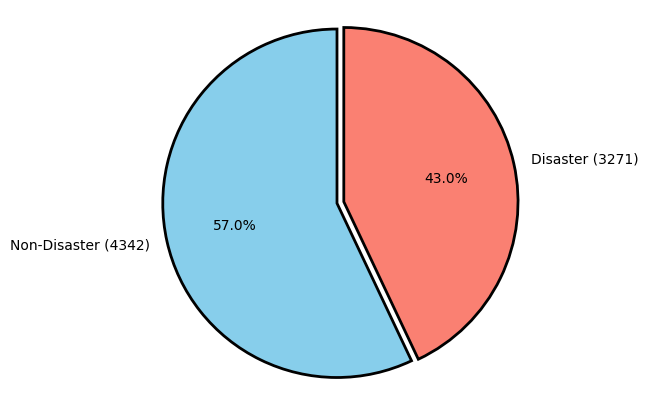

In [5]:
counts = [sum(train_data["target"] == 0), sum(train_data["target"] == 1)]
labels = [f"Non-Disaster ({counts[0]})", f"Disaster ({counts[1]})"]
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(counts, labels=labels, colors=["skyblue", "salmon"], autopct="%1.1f%%", startangle=90, wedgeprops={"edgecolor": "black", "linewidth": 2}, explode=[0.02] * 2)
ax.axis("equal")
plt.show()

Let's also take a look at top words in Keyword and Location columns for each target

In [6]:
def display_top_words(col, target, n=30):
    plt.figure(figsize=(9,6))
    data = train_data[train_data["target"] == target][col.lower()].value_counts().nlargest(n)
    data.plot(kind="barh", color="skyblue" if target == 0 else "salmon")
    plt.title(f'Top {n} {col.capitalize()} in train_data ({"Non-Disaster" if target == 0 else "Disaster"})')
    plt.xlabel("Word Count")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

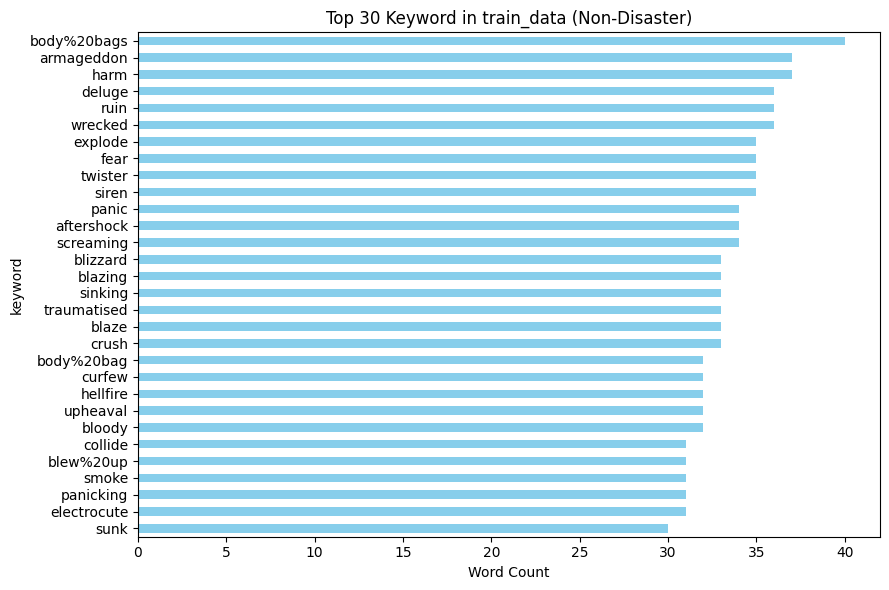

In [7]:
display_top_words("keyword", 0)

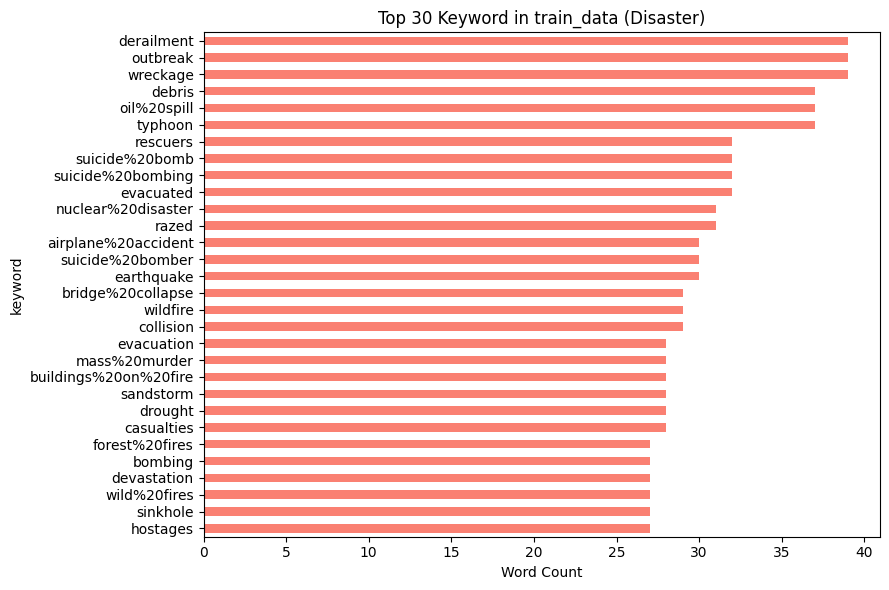

In [8]:
display_top_words("keyword", 1)

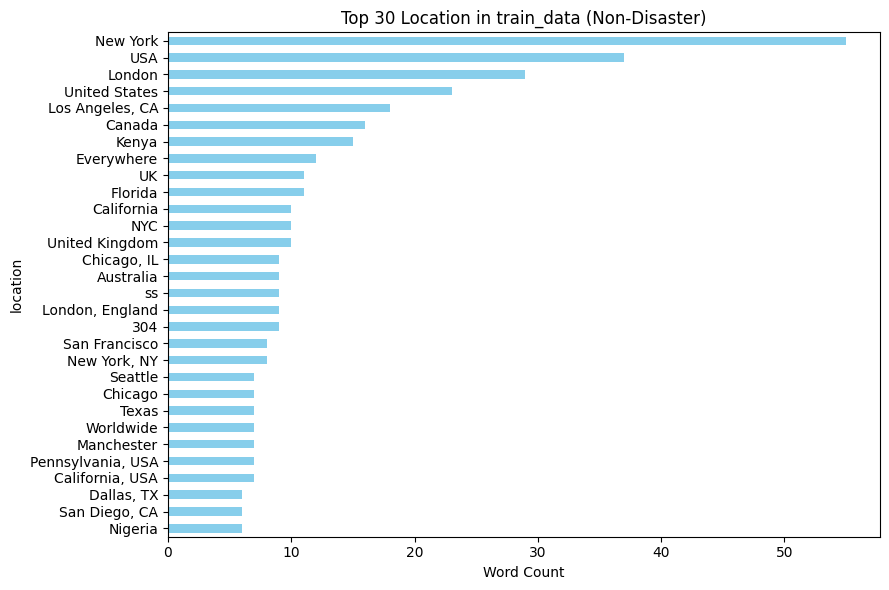

In [9]:
display_top_words("location", 0)

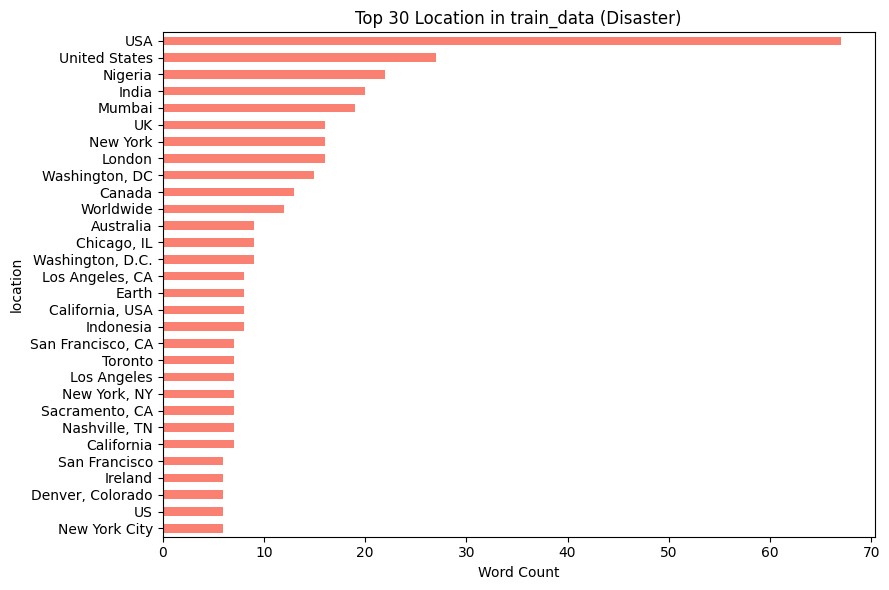

In [10]:
display_top_words("location", 1)

The following function displays distribution of number of words in tweet for each target. We can see that they both follow a distribution that is close to normal distribution, but spread more broadly across different frequencies. The distribution does not provide much information in distinguishing a particular type of tweet.

In [11]:
def display_n_words_per_tweet_dist(target):
    data = train_data[train_data["target"] == target]["text"]
    n_words = data.apply(lambda x: len(x.split()))
    
    # plot Kernel Density Estimation
    plt.figure(figsize=(9,6))
    plt.hist(n_words, bins=30, density=True, color="skyblue", edgecolor="black")
    kde = gaussian_kde(n_words)
    x_axis = np.linspace(n_words.min(), n_words.max(), 500)
    plt.plot(x_axis, kde(x_axis), color="darkblue", lw=2, label="Kernel Density Estimation")
    plt.title(f"Number of Words Per Tweet ({'Non-Disaster' if target == 0 else 'Disaster'})")
    plt.xlabel("Number of Words")
    plt.ylabel("Density")
    plt.tight_layout()

    # plot Normal Distribution
    mean = np.mean(n_words)
    std = np.std(n_words)
    plt.plot(x_axis, norm.pdf(x_axis, mean, std), color='red', lw=2, label="Normal Distribution")
    plt.legend()

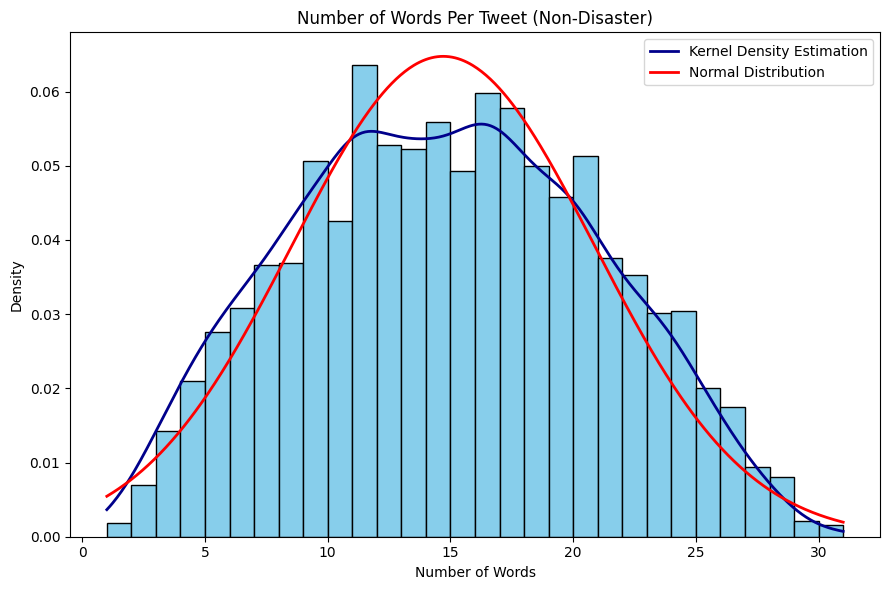

In [12]:
display_n_words_per_tweet_dist(target=0)

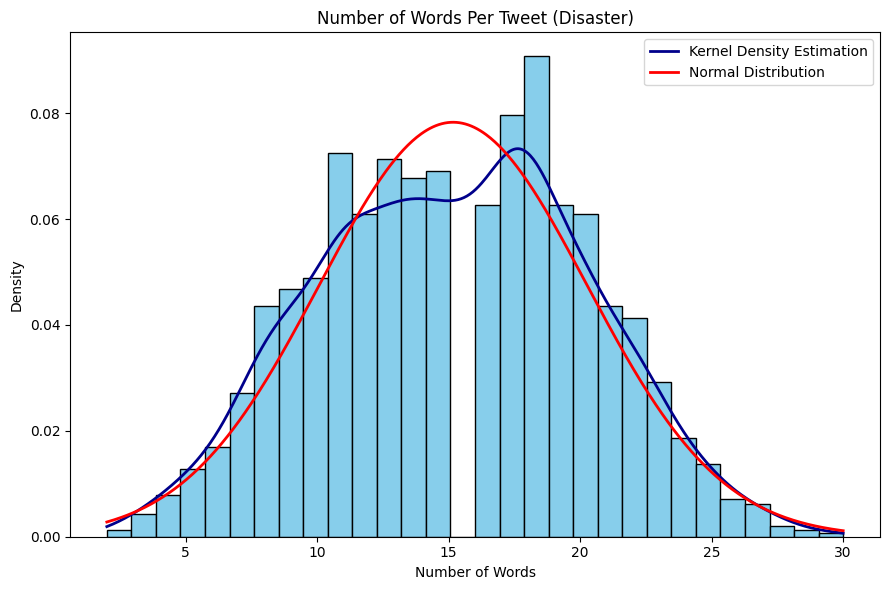

In [13]:
display_n_words_per_tweet_dist(target=1)

**<h3>Text Data Preprocessing</h3>**

Although a tweet contains lots of text information for model training and prediction, not all the contents are useful, e.g. urls, html tags and punctuations do not provide any sentimental or semantic information; abbreviations compress information that could be useful in model training to a form only human can understand; stop words, like “the”, “and”, “is”, “in”, “of”, contribute less to sentiment/semantics of a sentence and more to grammar. We need to process the text to remove useless and noisy data, and extract useful information from abbreviations. Thanks to this project on Kaggle: https://www.kaggle.com/code/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing/notebook, which already summarized common abbreviations and the complete words it stands for, we will use this list below.

In [14]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

The `clean_text` function will perform:

- remove urls, html tags, punctuations from tweets
- replace abbreviations with complete words
- remove stop words

In [15]:
def remove_url(s):
    pat = re.compile(r'https?://\S+|www\.\S+')
    return pat.sub('', s)

def remove_html_tags(s):
    pat = re.compile(r'<.*?>')
    return pat.sub('', s)

def remove_puncs(s):
    should_keep = set(string.printable) - set(string.punctuation)
    return ''.join(c for c in s if c in should_keep)

def replace_abbrs(s):
    res = []
    for w in s.split():
        res.append(abbreviations.get(w.lower(), w))
    return " ".join(res)

def remove_stopwords(s):
    sw = set(stopwords.words("english"))
    return [w for w in s.split() if w.lower() not in sw]

def clean_text(s):
    s = remove_url(s)
    s = remove_html_tags(s)
    s = remove_puncs(s)
    s = replace_abbrs(s)
    return remove_stopwords(s)

train_data["cleaned_text"] = train_data["text"].apply(clean_text)
test_data["cleaned_text"] = test_data["text"].apply(clean_text)

**<h3>RNN Model Training with LSTM</h3>**

We are now ready to build a Recurrent Neural Network(RNN) for text classification. As we learned, traditional RNN is slow to train, and can suffer from exploding/vanishing gradient. Therefore, we will utilize Long Short‑Term Memory(LSTM) to better train long temporal dependencies, like tweet sentences in our case. We will also add some dropout to avoid overfitting.

In [16]:
def build_rnn(
    epochs=10,
    batch_size=32,
    pad_maxlen=50,
    input_dim=4096,
    output_dim=128,
    lstm_units=128,
    dr=0.4,
    lr=0.0001,
    random_state=42
):
    tokenizer = Tokenizer(num_words=input_dim, split=" ")
    tokenizer.fit_on_texts(train_data["cleaned_text"])
    
    X = tokenizer.texts_to_sequences(train_data["cleaned_text"])
    X = pad_sequences(X, maxlen=pad_maxlen)
    y = train_data["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # RNN with LSTM
    rnn = Sequential()

    # Embedding layer
    rnn.add(Embedding(input_dim, output_dim))
    rnn.add(Dropout(dr))
    
    # LSTM layers
    rnn.add(LSTM(lstm_units, dropout=dr, return_sequences=True, recurrent_dropout=dr))
    rnn.add(Dropout(dr))
    rnn.add(LSTM(lstm_units, dropout=dr, recurrent_dropout=dr))
    rnn.add(Dropout(dr))
    
    # Output layer
    rnn.add(Dense(1, activation="sigmoid"))

    # Compile model and train
    rnn.compile(
        loss=binary_crossentropy,
        optimizer=Adam(learning_rate=lr), 
        metrics=["accuracy"]
    )
    rnn.fit(X, y, epochs=epochs, validation_split=0.2, batch_size=batch_size)

    test_tweets = tokenizer.texts_to_sequences(test_data["cleaned_text"])
    test_tweets = pad_sequences(test_tweets, maxlen=pad_maxlen)
    
    return rnn, X_train, X_test, y_train, y_test, test_tweets

In [17]:
# configure to train the model with more epochs
model, X_train, X_test, y_train, y_test, test_tweets = build_rnn(epochs=10)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.5752 - loss: 0.6790 - val_accuracy: 0.5345 - val_loss: 0.6825
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5828 - loss: 0.6687 - val_accuracy: 0.5364 - val_loss: 0.6724
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.6263 - loss: 0.6505 - val_accuracy: 0.6783 - val_loss: 0.6448
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7156 - loss: 0.5993 - val_accuracy: 0.7472 - val_loss: 0.5758
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.7900 - loss: 0.4857 - val_accuracy: 0.7669 - val_loss: 0.4983
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8199 - loss: 0.4212 - val_accuracy: 0.7728 - val_loss: 0.4815
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8340 - loss: 0.3907 - val_accuracy: 0.7781 - val_loss: 0.4761
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8455 - loss: 0.3665 - 

**<h3>Model Evaluation</h3>**

Let's evaluate the model performance by examining the confusion matrix and ROC curve.

In [18]:
y_pred = model.predict(X_test).round()
accuracy = round(accuracy_score(y_test, y_pred), 2)
recall = round(recall_score(y_test, y_pred), 2)
precision = round(precision_score(y_test, y_pred), 2)
print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Accuracy: 0.86
Recall: 0.78
Precision: 0.88


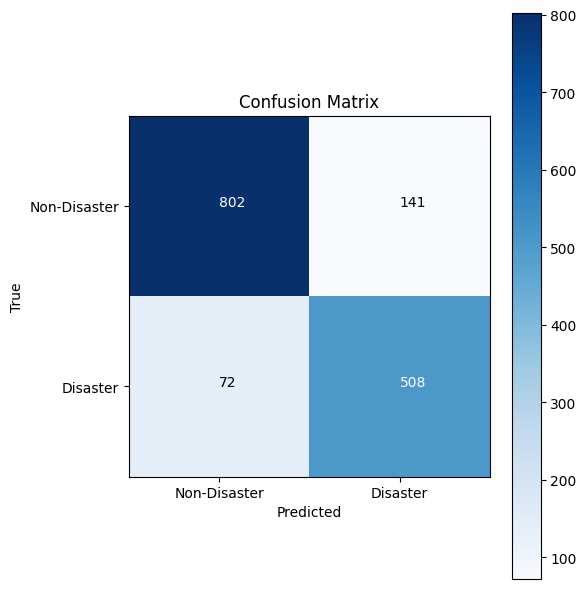

In [19]:
cm = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=["Non-Disaster", "Disaster"],
    yticklabels=["Non-Disaster", "Disaster"],
    ylabel="True",
    xlabel="Predicted",
    title="Confusion Matrix"
)
threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(i, j, cm[i, j], color="white" if cm[i, j] > threshold else "black")
plt.tight_layout()
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


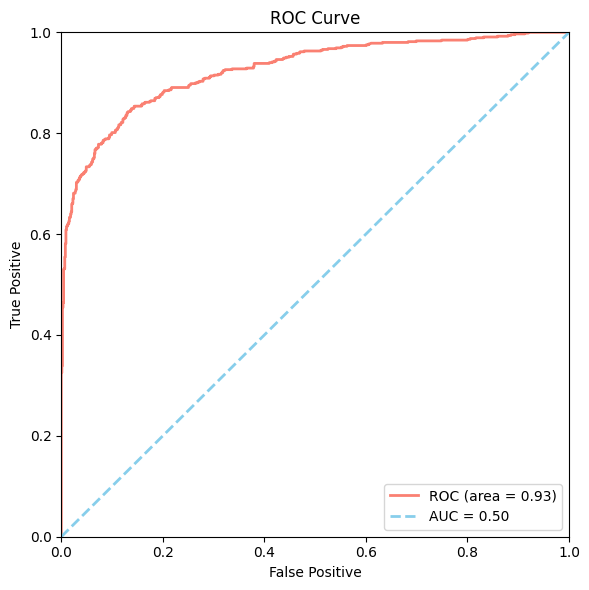

In [20]:
y_pred_proba = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = round(auc(fpr, tpr), 2)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="salmon", lw=2, label=f'ROC (area = {roc_auc})')
plt.plot([0,1], [0,1], color="skyblue", lw=2, linestyle='--', label="AUC = 0.50")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       874
           1       0.88      0.78      0.83       649

    accuracy                           0.86      1523
   macro avg       0.86      0.85      0.85      1523
weighted avg       0.86      0.86      0.86      1523



The model performed pretty well given that we didn't train and tune it for a lot of iterations. To further improve the model, I think we should focus more on improving recall score in our case, because in general, misclassifying non-disaster tweets as disaster tweets (false positive) is acceptable, while misclassifying disaster tweets as non-disaster tweets (false negative) can cause serious consequences like delayed rescues and evacuation.

**<h3>Test Data Predictions and Submission</h3>**

In [22]:
# submission["target"] = np.round(model.predict(test_tweets)).astype(int)
# submission.to_csv(submission_path, index=False)
# submission.head()

![Alt text](./submission-screenshot.png)

**<h3>Conclusion</h3>**

Predicting if a real disaster is happening using tweets has potential to create great social impact, for example, government can use it to organize rescues and evacuation in a more timely manner to reduce casualties. In this project, I enhanced the skill of building RNN using tensorflow/keras, gained lots of knowledge in text processing, expecially how to remove minimally-useful content from the text. And also learned the drawbacks of traditional RNN and how using LSTM can improve model quality when dealing with long temporal dependencies.


**<h3>References</h3>**

Up-to-date list of Slangs for Text Preprocessing: https://www.kaggle.com/code/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing/notebook

Keras: The high-level API for TensorFlow: https://www.tensorflow.org/guide/keras

Long Short-Term Memory layer - Hochreiter 1997: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM